In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
#all labels:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../data/pchembl_chemicals.csv')
targets = pd.read_csv('../data/subset_targets.csv')

In [4]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 249/85681 [00:00<00:34, 2479.39it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [01:00<00:00, 5585.28it/s]


In [5]:
train, test, fps = utils.load_time_split(year=2030, return_fingerprints=True) #set a year after now

In [6]:
##The following is to calculate AVE bias:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A


In [7]:
probability_arr = probability_matrix.toarray()

In [8]:
arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Sorted array indices:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [9]:

n = 500000
probs = probability_arr[arr_sorted[:n][:,0], arr_sorted[:n][:,1]]

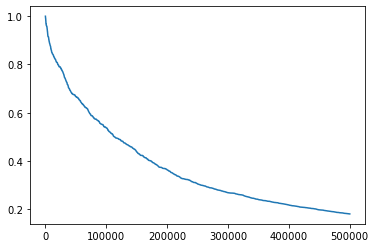

In [10]:
import matplotlib.pyplot as plt
plt.plot(probs)

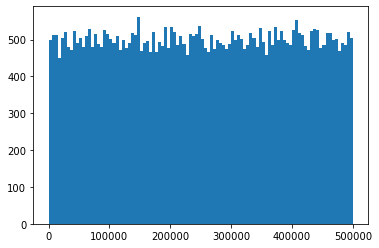

In [16]:
_ =plt.hist(np.random.choice(n, 50000, replace=False), bins=100)

In [17]:
##Test that it lines up:
for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)


C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

In [18]:
def get_nnrank_of_target(ligand_idx, target_idx):
    positives = interaction_matrix[ligand_idx].nonzero()[1]
    all_distances = all_distances =fast_jaccard(fps[ligand_idx], fps)[0]
    s = np.argsort(all_distances)
    
    pred = target_idx
    curr_rank = 0
    count=1
    preds = []
    seen = []

    while pred not in preds:
        predictions = interaction_matrix[s[count]].nonzero()[1]
    
        preds = np.setdiff1d(predictions,positives)
        preds = np.setdiff1d(preds, seen)
        seen += list(preds)
        curr_rank += 0 if len(preds)<1 else np.mean(np.arange(len(preds))+1)

        count+=1
    return curr_rank
    #rank = (np.array(seen)[np.sort(np.unique(seen, return_index=True)[1])] == pred).nonzero()[0] + 1
    return rank

In [19]:
def clean_text(input_string):
    #source: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    #replace these with whitespace:
    clean_string = re.sub(r"""
               [(),.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               input_string.lower(), flags=re.VERBOSE)
    
    #replace these with nothing:
    clean_string = clean_string.replace('-', '')
    clean_string = clean_string.replace('=', '')
    return clean_string


def get_synonyms(tid):
    target = new_client.target
    res = target.filter(target_chembl_id=tid)
    target_synonyms = [i['component_synonym'] for i in res[0]['target_components'][0]['target_component_synonyms']]
    #clean:
    target_synonyms = [clean_text(i) for i in target_synonyms]
    #make all lowercase to improve correct matchings:
    #target_synonyms = [i.lower() for i in target_synonyms]
    #remove all punctuations to improve correct matchings:
    #target_synonyms = [i.translate(str.maketrans('', '', string.punctuation)) for i in target_synonyms]
    
    return target_synonyms

def get_cid(smi):
    try:
        c = pcp.get_compounds(smi, 'smiles')[0]
        return c.cid
    except Exception as e:
        print(e)
        return None

def get_assay_summary(cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON').content)
    return b

def get_relevant_aids(assay_summary, synonyms):
    #iterates through all assays and checks for overlap in Assay Name with any of the synonyms. 
    #if there is a shared word, returns the pubchem assay ID. 
    #relevant_aids = list()
    bioactivity_outcomes = list()
    assay_names = list()
    
    for i in assay_summary['Table']['Row']:
        assay_name = i['Cell'][11]
        #trick from word embedding - remove all punctuations to improve word matching
        #assay_name = assay_name.translate(str.maketrans('', '', string.punctuation))
        clean_assay_name = clean_text(assay_name)
        #now match words:
        if len(set(synonyms).intersection(clean_assay_name.split()))>0:
            
            ###This is the variable that stores the 'active' or 'unspecified' or 'inactive' string:
            bioactivity_outcome = i['Cell'][6]
            ###
            
            bioactivity_outcomes.append(bioactivity_outcome)
            assay_names.append(assay_name)
            
            #this stores the AID number
            #relevant_aids.append(i['Cell'][0])

    return bioactivity_outcomes, assay_names#relevant_aids

def get_assay_details(aid, cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'+str(aid)+'/JSON?cid='+str(cid)).content)
    return b

def get_pair_details(pair):
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    instance_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['chembl_id'].iloc[0]
    return smi, instance_id, tid, predicted_target


In [20]:
def fetch_assay_details(tid, smi):
    if tid in synonym_dict:
        synonyms = synonym_dict[tid]
    else:
        synonyms = get_synonyms(tid)
        synonym_dict[tid] = synonyms

        
    if smi in cid_dict:
        compound_id = cid_dict[smi]
    else:
        compound_id = get_cid(smi)
        cid_dict[smi] = compound_id
        
    if compound_id in assay_dict:
        assay_summary = assay_dict[compound_id]
    else: 
        assay_summary = get_assay_summary(compound_id)
        assay_dict[compound_id]=assay_summary
        
    return synonyms, compound_id, assay_summary

In [ ]:

# import time as time
# import signal
# #Close session
# def handler(signum, frame):
#     raise Exception('Action took too much time')
# signal.signal(signal.SIGALRM, handler)
# signal.alarm(35) #Set the parameter to the amount of seconds you want to wait



synonym_dict = dict()
cid_dict = dict()
assay_dict = dict()
assays_long = pd.DataFrame(columns=['ligandIdx', 'targetIdx', 'instance_id', 'pref_name', 'outcome', 'assayname'])
rownum=0

    
resultdict = dict()


for count, pair in tqdm_notebook(enumerate(arr_sorted[:10000]), smoothing=0, total=10000):
    print(f'testing {count}th pair: {pair} ... ', end=' ')
    
    #first, check if it would have been predicted using nearest neighbors anyway:
    rank = get_nnrank_of_target(pair[0], pair[1])
    if rank>3:
        pass
    else:
        print(f'skipping, rank was {rank}')
        resultdict[count] = 'lowrank'
        continue
        
    #next, ping pubchem for assays. 
    try:
        smi, instance_id, tid, pref_name = get_pair_details(pair)
    
        synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
        if 'Fault' in assay_summary.keys():
            None
            #print('No assays present.')
        else:
            bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
            print(bioactivity_outcomes)
            for outcome, aname in zip(bioactivity_outcomes, assay_names):
                assays_long.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
                resultdict[count] = 'success'
                rownum += 1
    
        if count%100==0:
            assays_long.to_csv('assays_long.csv')
        print(' - finished.')
    except KeyboardInterrupt:
        raise
    except (Exception):
        resultdict[count] = 'exception'
        print('took too long. moving on.')



/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


testing 0th pair: [328242    138] ...  skipping, rank was 3.0
testing 1th pair: [68104   138] ...  skipping, rank was 1.5
testing 2th pair: [315225     72] ...  ['Inactive', 'Unspecified', 'Unspecified', 'Unspecified', 'Unspecified']
 - finished.
testing 3th pair: [68544   138] ...  skipping, rank was 1.5
testing 4th pair: [67490   138] ...  took too long. moving on.
testing 5th pair: [68211   138] ...  []
 - finished.
testing 6th pair: [68422    72] ...  took too long. moving on.
testing 7th pair: [68566    72] ...  

Exception ignored in: <generator object tqdm.__iter__ at 0x7fee2ab11ed0>
Traceback (most recent call last):
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/tqdm/std.py", line 1183, in __iter__
    self.close()
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/tqdm/notebook.py", line 255, in close
    self.sp(bar_style='danger')
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/tqdm/notebook.py", line 184, in display
    pbar.bar_style = bar_style
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type


Traceback (most recent call last):
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-7d0f342315bd>", line 25, in <module>
    rank = get_nnrank_of_target(pair[0], pair[1])
  File "<ipython-input-18-d1231f84a543>", line 3, in get_nnrank_of_target
    all_distances = all_distances =fast_jaccard(fps[ligand_idx], fps)[0]
  File "<ipython-input-6-b8325076f4ee>", line 14, in fast_jaccard
    Y = Y.astype(bool).astype(int)
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/scipy/sparse/data.py", line 72, in astype
    self._deduped_data().astype(dtype, casting=casting, copy=copy),
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/IPython/core/interactive

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-7d0f342315bd>", line 25, in <module>
    rank = get_nnrank_of_target(pair[0], pair[1])
  File "<ipython-input-18-d1231f84a543>", line 3, in get_nnrank_of_target
    all_distances = all_distances =fast_jaccard(fps[ligand_idx], fps)[0]
  File "<ipython-input-6-b8325076f4ee>", line 14, in fast_jaccard
    Y = Y.astype(bool).astype(int)
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/scipy/sparse/data.py", line 72, in astype
    self._deduped_data().astype(dtype, casting=casting, copy=copy),
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/IPython/core/interactives

In [18]:



synonym_dict_mid = dict()
cid_dict_mid = dict()
assay_dict_mid = dict()
assays_long_mid = pd.DataFrame(columns=['ligandIdx', 'targetIdx', 'instance_id', 'pref_name', 'outcome', 'assayname'])
rownum_mid=0

    
resultdict_mid = dict()


for count, pair in tqdm_notebook(enumerate(arr_sorted[10000:20000]), smoothing=0, total=10000):
    print(f'testing {count}th pair: {pair} ... ', end=' ')
    
    #first, check if it would have been predicted using nearest neighbors anyway:
    rank = get_nnrank_of_target(pair[0], pair[1])
    if rank>3:
        pass
    else:
        print(f'skipping, rank was {rank}')
        resultdict[count] = 'lowrank'
        continue
        
    #next, ping pubchem for assays. 
    try:
        smi, instance_id, tid, pref_name = get_pair_details(pair)
    
        synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
        if 'Fault' in assay_summary.keys():
            None
            #print('No assays present.')
        else:
            bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
            for outcome, aname in zip(bioactivity_outcomes, assay_names):
                assays_long_mid.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
                resultdict_mid[count] = 'success'
                rownum_mid += 1
    
        if count%100==0:
            assays_long_mid.to_csv('assays_long.csv')
        print(' - finished.')
    except (KeyboardInterrupt, Exception):
        resultdict_mid[count] = 'exception'
        print('took too long. moving on.')
        
        

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


testing 0th pair: [305639    215] ...   - finished.
testing 1th pair: [300900     86] ...   - finished.
testing 2th pair: [110653    214] ...   - finished.
testing 3th pair: [12480    94] ...   - finished.
testing 4th pair: [67179   142] ...   - finished.
testing 5th pair: [336258     91] ...   - finished.
testing 6th pair: [68378   164] ...   - finished.
testing 7th pair: [225050    170] ...   - finished.
testing 8th pair: [76914   170] ...  skipping, rank was 1.5
testing 9th pair: [78010   170] ...  skipping, rank was 1.0
testing 10th pair: [296941    170] ...  skipping, rank was 2.5
testing 11th pair: [77840   170] ...  


KeyboardInterrupt: 

In [68]:
both = 0
neg = 0
pos = 0
positive_targs = list()
both_targs = list()
negative_targs= list()

for count, item in enumerate(assay_keeper):
    active = 'Active' in item['Outcome'].tolist()
    inactive = 'Inactive' in item['Outcome'].tolist()
    
    if active and inactive:
        both += 1
        both_targs.append(count)
    elif active:
        pos += 1
        positive_targs.append(count)
    elif inactive:
        neg += 1
        negative_targs.append(count)

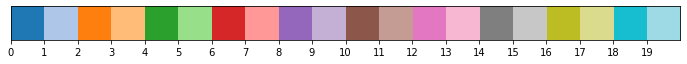

In [70]:
##Use this to choose colours for the horizontal barplots
from matplotlib import colors

def view_colormap(cmap):
    """Plot a colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

In [71]:
def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm

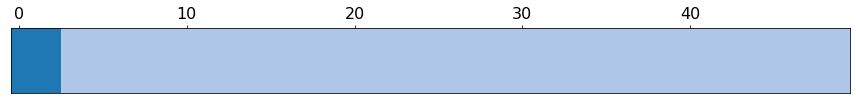

In [72]:
cmap = makeCmap('tab20', [0, 1])


arr = np.zeros([50,1])
arr[0:both+pos+neg] = 0
arr[both+pos+neg:] = 1

#cmap = plt.get_cmap('tab20')
#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
ax.xaxis.tick_top()
ax.set_yticks([])

ax.tick_params(axis="x", labelsize=16)
ax.imshow(arr.T, cmap=cmap, aspect='auto')
plt.tight_layout()
#fig.savefig('total_assays.png')

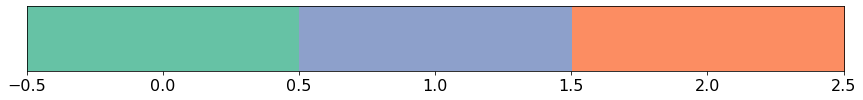

In [73]:
#Use this when you have active, inactive, and ambiguous evidence
#cmap = makeCmap('Set2', [1,2,0])

#Use this for the demo, where we only have active evidence (the 
#order gets messed up when there's only one type of result)
cmap = makeCmap('Set2', [0,2,1])


arr = np.zeros([pos+both+neg,1])
arr[0:neg] = 0
arr[neg:neg+both] = 1
arr[neg+both:] = 2


#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
#ax.xaxis.tick_top()
ax.set_yticks([])
ax.tick_params(axis="x", labelsize=16)
plt.tight_layout()
ax.imshow(arr.T, cmap=cmap, aspect='auto')

#fig.savefig('assay_results.png')

In [76]:
targs = list()

for count, pair in enumerate(arr_sorted[:10000]):
    predicted_target = targets['pref_name'].iloc[pair[1]]
    targs.append(predicted_target)
    
pdf = pd.DataFrame(targs)

a= pdf.iloc[positive_targs][0].value_counts()

In [83]:
#Print out percentages of ambiguous evidence, negative evidence, and positive evidence
tot = both+pos+neg
print('Num negative assays:', neg)
print(neg/tot*100)

print('Num with ambiguous assay evidence:', both)
print(both/tot*100)

print('Num with positive assay evidence:', pos)
print(pos/tot*(100))


Num negative assays: 1
33.33333333333333
Num with ambiguous assay evidence: 1
33.33333333333333
Num with positive assay evidence: 1
33.33333333333333
